# [Paid operational RAG] Langchain | LangGraph | Claude3.5 | Wevieate | Cohere | Tavily(advanced) | Fastapi | Streamlit

## Query Router | Hallucination Grader | Reranker | Web Search

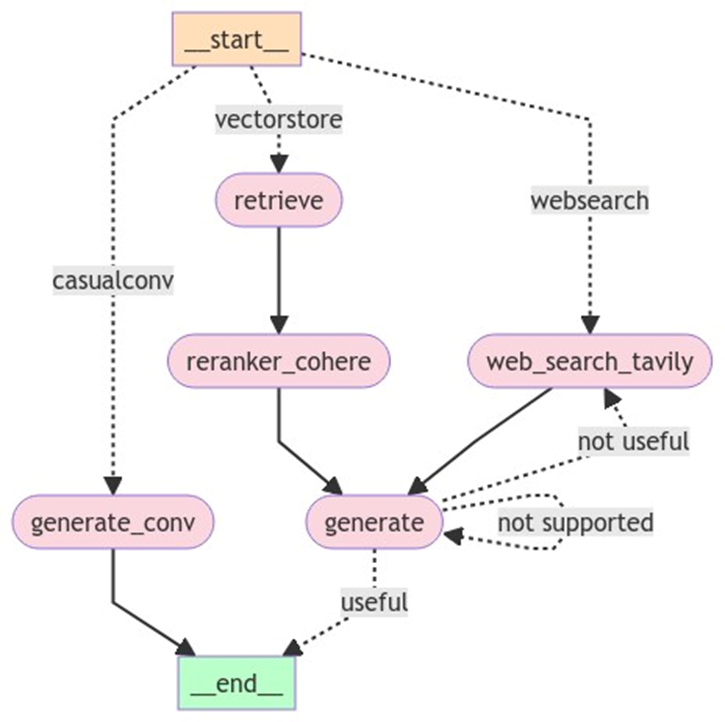

# import

In [2]:
import os
from dotenv import load_dotenv
import weaviate
import json
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import openai
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_vertexai import VertexAIEmbeddings 
import re
from langchain_anthropic import ChatAnthropic
import anthropic
load_dotenv()

False

# API keys

In [3]:
TAVILY_API_KEY = ""
Openai_API_KEY = ""
GROQ_API_KEY = ""
coher_API_KEY = ""
claude_api_key=""

# LLM setting

In [4]:
# llm = ChatGroq(temperature=0, groq_api_key=GROQ_API_KEY)

In [5]:
# llm = anthropic.Anthropic(api_key=claude_api_key)

In [6]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620",api_key=claude_api_key)

# prepare embedding model (openai)

In [7]:
os.environ["OPENAI_API_KEY"] =  Openai_API_KEY
openai.api_key =os.getenv("OPENAI_API_KEY")
embed_model = "text-embedding-ada-002"
embeddings = OpenAIEmbeddings(model=embed_model)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [10]:
def get_embedding(text, engine="text-embedding-ada-002") : 
    res = openai.Embedding.create(input=text,engine=engine)['data'][0]['embedding']
    # from openai import OpenAI
    # embedding_client = OpenAI(api_key=Openai_API_KEY)
    # res= embedding_client.embeddings.create(input = text, model=engine).data[0].embedding
    return res

In [11]:
get_embedding("현재 시점 이후의 token들에 대해 masking 처리를 하여 Masked Multi-Head Self-Attention을 사용한다.")

[-0.054653700441122055,
 -0.019279181957244873,
 -0.008386376313865185,
 -0.02194819040596485,
 0.0063812327571213245,
 0.015973404049873352,
 -0.020430784672498703,
 0.007336385548114777,
 -0.020146271213889122,
 0.009002822451293468,
 0.02202947996556759,
 0.018019191920757294,
 -0.008664115332067013,
 -0.010655710473656654,
 0.012227309867739677,
 -0.00718735484406352,
 0.021175937727093697,
 -0.007627673447132111,
 -0.0021270776633173227,
 -0.03495452553033829,
 -0.0019526437390595675,
 0.013019883073866367,
 -0.021324969828128815,
 -0.017572099342942238,
 -0.01474051270633936,
 0.0017883710097521544,
 0.0005249952664598823,
 -0.03292228281497955,
 -0.010825064033269882,
 -0.020349495112895966,
 0.011671830900013447,
 -0.01326375175267458,
 0.01159054134041071,
 -0.005500595550984144,
 -0.008847016841173172,
 0.01961788721382618,
 0.008047669194638729,
 -0.018235964700579643,
 0.004240606911480427,
 0.00279771676287055,
 -0.00515511492267251,
 0.005490434356033802,
 0.0236688200384

# TypedDict (to apply to workflow functions)

In [12]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the stat.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]
    source: List[dict]

# Query Router(web or db)

## Query Router Test / prepare

In [13]:
### Router
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "websearch", "casualconv"] = Field(
        ...,
        description="Given a user question choose to route it to casual conversation or web search or a vectorstore.",
    )

# LLM with function call 
"""
ref.
https://python.langchain.com/v0.2/docs/integrations/chat/groq/
Supported Models: https://console.groq.com/docs/models
"""

# client = Groq(
#     api_key=GROQ_API_KEY
# )

# llm = client.chat.completions.create(
#     messages=[
#         {
#             "role": "user",
#             "content": "Explain the importance of fast language models",
#         }
#     ],
#     model="llama3-8b-8192",
# )

structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
# system = """You are an expert at routing a user question to a vectorstore or web search.
# The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
# Use the vectorstore for questions on these topics. For all else, use web-search."""
# route_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system),
#         ("human", "{question}"),
#     ]
# )

# question_router = route_prompt | structured_llm_router
# print(question_router.invoke({"question": "Who will the Bears draft first in the NFL draft?"}))
# print(question_router.invoke({"question": "What are the types of agent memory?"}))

system = """You are an expert at routing a user question to a vectorstore or web search or casual conversation.
The vectorstore contains documents related to language processing, and artificial intelligence.
Use the vectorstore for questions on these topics. For all else, use web-search.
If the question is a casual conversation use original knowledge"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "2023년 두산 베어스 1번 타자는 누구야?"}))
print(question_router.invoke({"question": "LLaMa3의 구조에 대해 설명해줘"}))
print(question_router.invoke({"question": "안녕"}))

datasource='websearch'
datasource='vectorstore'
datasource='casualconv'


## Query Router Def

In [14]:
def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})   
    if source.datasource == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source.datasource == 'casualconv':
        print("---ROUTE QUESTION TO CASUAL CONV.---")
        return "casualconv"


# Build VectorDB (Weaviate)

## Test VectorDB

### split / chunking

In [73]:
import requests
from bs4 import BeautifulSoup
request1 = requests.get("https://finddme.github.io/")
html1 = request1.text
soup1 = BeautifulSoup(html1, 'html.parser')
links1 = soup1.select('h4 > a')
urls=[]
tags=["llm","dev","natural"]
for link in links1:
    res={"title":"","url":""}
    if link.has_attr('href'):
        href=link.get('href')
        for t in tags:
            if t in href.split("/")[1]:
                # urls.append("https://finddme.github.io"+href)
                res["title"]+=link.find("li").get_text().strip("\n        ")
                res["url"]+="https://finddme.github.io"+href
                urls.append(res)

In [74]:
urls

[{'title': 'Self-Reflective RAG (세 가지 Grader) : Langchain | LangGraph | GROQ | Wevieate | Tavily | Chainlit\n      01 Jul 2024',
  'url': 'https://finddme.github.io/llm%20/%20multimodal/2024/07/01/self_ref_rag/'},
 {'title': 'MoE, MoA 믹스는 다가와 아 오에이\n      22 Jun 2024',
  'url': 'https://finddme.github.io/llm%20/%20multimodal/2024/06/22/merge2/'},
 {'title': 'Merge algorithms\n      20 Jun 2024',
  'url': 'https://finddme.github.io/llm%20/%20multimodal/2024/06/20/merge/'},
 {'title': 'DocLLM: A layout-aware generative language model for multimodal document understanding\n      04 Jun 2024',
  'url': 'https://finddme.github.io/llm%20/%20multimodal/2024/06/04/docllm/'},
 {'title': 'VLM : Models Summary(unfinished post)\n      30 May 2024',
  'url': 'https://finddme.github.io/llm%20/%20multimodal/2024/05/30/vlm_models/'},
 {'title': 'VLM : Architecture / Fusion Methods\n      29 May 2024',
  'url': 'https://finddme.github.io/llm%20/%20multimodal/2024/05/29/vlm_architecture/'},
 {'title': '

In [99]:
# urls = [
#     "https://finddme.github.io/llm%20/%20multimodal/2023/10/01/llm_architecture/",
#     "https://finddme.github.io/llm%20/%20multimodal/2024/02/21/RAG/",
#     "https://finddme.github.io/llm%20/%20multimodal/2024/05/01/llama3/",
# ]
"""
normal
"""
# docs = [WebBaseLoader(url["url"]).load() for url in urls]
"""
metadata title 수정
"""
docs =[]
for url in urls:
    w_context=WebBaseLoader(url["url"]).load()[0]
    w_context.metadata["title"] = url["title"]
    docs.append([w_context])

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [98]:
len(docs[0])

1

In [101]:
docs_list[0].metadata

{'source': 'https://finddme.github.io/llm%20/%20multimodal/2024/07/01/self_ref_rag/',
 'title': 'Self-Reflective RAG (세 가지 Grader) : Langchain | LangGraph | GROQ | Wevieate | Tavily | Chainlit\n      01 Jul 2024',
 'language': 'en-us'}

In [31]:
# import re
# space_check=re.compile("\s{1,}")
# re.sub(space_check," ",'Decoder\n    \nencoding 된 representation을을 받아 모델의 출력을 생성하는 부분.\ninput\n        \n학습 시에는 정답 sequence(shifted right)가 입력되고, 추론 시에는 이전에 예측된 token이 입력된다.')

In [108]:
# make chunks
space_check=re.compile("\s{1,}")
chunks=[]
pass_first=["finddme ","⊹  Portfolio","© 2024 viein_serenity_singularity_simplicity_savage. This work is liscensed under CC BY-NC 4.0."]
for i in doc_splits:
    # c={'text':i.page_content, 'title':i.metadata["source"].split("/")[-2]}
    c={'text':i.page_content, 'source_title':i.metadata["title"], "source":i.metadata["source"]}
    if c["text"].split("\n")[0] in pass_first:pass
    else:
        # save_c={'text':re.sub(space_check," ",c['text']),'title':c['title']}
        save_c={'text':re.sub(space_check," ",c['text']),'source_title':c['source_title'],'source':c['source']}
        chunks.append(save_c)

<>:2: DeprecationWarning: invalid escape sequence '\s'
<>:2: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_1714/2286961391.py:2: DeprecationWarning: invalid escape sequence '\s'
  space_check=re.compile("\s{1,}")


In [109]:
len(chunks)

521

In [110]:
chunks

[{'text': 'llama_index -> FlagEmbeddingReranker(?) huggingface rerank model langchain_community -> JinaRerank langchain_cohere -> CohereRerank Application Interface FastAPI (graphic interface o) Flask Gradio (graphic interface o) Streamlit (graphic interface o) cherrypy Django Chainlit ... RAG 개발 예시 (인터넷 접속 가능 환경) 기능별 구성 요약 Illustrated by the author RAG Framework : Langchain Workflow control : LangGraph LLM : Mixtral-8x7b Inference accelerate : GROQ text embedding : Openai vector DB : Wevieate web search : Tavily Application Interface : Chainlit 단계별 설명 및 코드 Vector DB 준비 : Weaviate Illustrated by the author Weaviate setting weaviate docker setting weaviate docker-compose file: (https://weaviate.io/developers/academy/py/starter_multimodal_data/setup_weaviate/create_docker)[https://weaviate.io/developers/academy/py/starter_multimodal_data/setup_weaviate/create_docker] docker-compose -f wevieate.yml up -d -> weaviate client url 생성 create weaviate class client = weaviate.Client("weaviate cl

## save chunks

In [3]:
# db client 지정

client = weaviate.Client(
    url="http://192.168.2.186:8080"
)

/usr/local/lib/python3.10/dist-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.2. The latest version is 4.6.5.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


In [111]:
client.batch.configure(batch_size=100)
# client.data_object.create(
#     class_name="JeopardyQuestion",
#     data_object={
#         "question": "This vector DB is OSS & supports automatic property type inference on import",
#         # "answer": "Weaviate",  # schema properties can be omitted
#         "newProperty": 123,  # will be automatically added as a number property
#     }
# )
with client.batch as batch:
    for i, chunk in enumerate(chunks):
        vector = get_embedding(chunk["text"])
        batch.add_data_object(data_object=chunk, class_name="B_with_title", vector=vector)

### save check

In [4]:
result = client.query.get("B_with_title", ["text","source_title","source"]).do()

In [115]:
result

{'data': {'Get': {'B_with_title': [{'source': 'https://finddme.github.io/natural%20language%20processing%20and%20linguistics/2021/04/04/DaCosta/',
     'source_title': 'Assessing the ability of Transformer-based Neural Models to represent structurally unbounded dependencies(Da Costa.J et al.(2020))\n      04 Apr 2021',
     'text': '실험 2도 1과 같이 모든 embedding level에서 주어 동사 일치와 불일치 간의 surprisal이 뚜렷하게 구분된다. 잘 파악하고 있다. 6.3 Experiment 3 result: Filler-gap surprisal in subject-inverted interrogatives 앞서 말했듯이 첫 번째와 네 번째 박스가 비문이고 두 번째와 세 번째가 정문이다. 비문에 해당하는 surprisal이 정문보다 높게 나와 모델이 학습을 잘 하는 것처럼 보이지만 본 논문에 따르면 wh-GAP과 nwh-nGAP이 둘 다 정문이기 때문에 surprisal이 비슷하게 나와야 하지만 wh-gap의 surprisal이 더 높게 나타나고 있다. 본 논문에서는 이와 같은 점이 조금 아쉽지만 전반적으로 주어-동사 도치 의문문의 dependency를 어느정도 잘 처리하고 있다고 볼 수 있다고 해석하였다. !!!!!!!! wh-GAP과 nwh-nGAP의 surprisal이 비슷해야 한다고…? 글쎄… 이는 유표성과 관련된다. wh-GAP과 nwh-nGAP 중 nwh-nGAP이 더 unmarked form이다. 자연어에서는 wh-question보다 non wh-question이 더 많이 쓰이기 때문에 사용 빈도 측면에서도, syntactic complexity 측면에서도 nwh-nGAP의 

In [6]:
client.query.aggregate("B_with_title").with_meta_count().do()

{'data': {'Aggregate': {'B_with_title': [{'meta': {'count': 521}}]}}}

# Retrieval

## Retrieval check

In [16]:
client = weaviate.Client(
    url="http://192.168.2.186:8080"
)

/usr/local/lib/python3.10/dist-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.2. The latest version is 4.7.1.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


In [17]:
weaviate_class="B_with_title"
property_list = list(map(lambda x: x["name"], client.schema.get(weaviate_class)['properties']))
query="LLaMa3의 구조에 대해 설명해줘"
query_vector = get_embedding(query)
response = client.query.get(weaviate_class, property_list).with_hybrid(query, vector=query_vector).with_limit(6).do()

In [18]:
response

{'data': {'Get': {'B_with_title': [{'source': 'https://finddme.github.io/llm%20/%20multimodal/2024/05/01/llama3/',
     'source_title': 'LLaMa 3\n      01 May 2024',
     'text': 'LLaMa 3 LLaMA 3는 Meta에서 공개한 Open Source LLM model로, LLaMa2에 이어 공개된 모델이다. LLaMA 3는 Instruct Model과 Pre-trained Model에 대해 각각 8B, 70B 두 사이즈가 공개되었다. Pretraining과 Post-training 방법의 개선으로 공개된 8B, 70B의 Pretrained, Instruction-fine-tuned model이 2024 4월18일 기준 해당 parameter scale 모델 중 가장 좋은 성능을 보인다고 한다. Post-training과정에서는 false refusal rate를 줄이고, model의 alignment를 개선하고, model response의 다양성을 증가시켰다. 특히 LLaMa 3는 2보다 코드 생성, instruction 수행 능력이 크게 향상되어 모델을 보다 다양하게 활용할 수 있을 것으로 보인다. LLaMa 3 개발 시 Meta팀은 benchmark 성능 향상 뿐만 아니라 실제 추론 능력(real-world scenario) 최적화에도 집중하였다고 한다. 실제 추론 능력 검증을 위해 새로운 high-quality human evaluation set을 개발했다고 한다. 해당 데이터는 12가지 use case에 대한 총 1,800개 prompt로 구성되어 있다. (12가지 use case: asking for advice, brainstorming, classification, closed question answering, coding, creative writing, extraction, inhabiting a 

## Retrieval def

In [19]:
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE from Vector Store DB---")
    question = state["question"]

    # Retrieval
    query_vector = get_embedding(question)
    documents = client.query.get("B_with_title", ["text","source_title","source"]).with_hybrid(question, vector=query_vector).with_limit(6).do()
    web_search = "No"
    return {"documents": documents, "question": question}

# Reranker

ref.

- Cross Encoder Reranker: (langchain) https://python.langchain.com/v0.2/docs/integrations/document_transformers/cross_encoder_reranker/

- (weaviate) reranker-cohere: https://weaviate.io/developers/weaviate/modules/retriever-vectorizer-modules/reranker-cohere

- <Reranker + Query Rewriting>(llamaindex) :

https://ai.gopubby.com/transforming-data-orchestration-the-query-pipeline-and-flagembedding-rerank-with-llamaindex-dee5a2e9a797

https://aksdesai1998.medium.com/advanced-rag-extracting-complex-pdfs-containing-tables-text-using-llamaparse-48b61693da58

- cohere (+qdrant)
https://medium.com/@parikshitsaikia1619/unlock-rags-potential-with-distance-metrics-and-rerankers-42df4f171f5a

In [20]:
import cohere

def reranker_cohere(state):
    co = cohere.Client(coher_API_KEY)
    
    """
    cohere models
    https://docs.cohere.com/docs/models
    """
    print("--- RERANK ---")
    question = state["question"]
    documents_or = state["documents"]

    documents=[r["text"] for r in documents_or["data"]["Get"]["B_with_title"]]
    source=[{"source_title":r["source_title"],"source":r["source"]} for r in documents_or["data"]["Get"]["B_with_title"]]
    
    rerank_res = co.rerank(
        model="rerank-multilingual-v3.0",
        query=question, # search query used for docs retrieval
        documents=documents, #list of retrieved docs
        top_n=4, # selecting top 4 docs
    )
    
    doc_txt = ""
    
    for idx,result in enumerate(rerank_res.results):
        doc_txt += f"doc {idx}. {documents[result.index]} \n"
        
    return {"documents": doc_txt, "question": question, "source": source}

# Grader 1 : Relevant Grader

- 검색된 doc이 relevant한지 아닌지 확인

Corrective RAG (CRAG): https://finddme.github.io/llm%20/%20multimodal/2024/02/21/RAG/#5-corrective-rag-crag

## Relevant Grader test / prepare

In [21]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
"""
pydantic_v1
- https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/pydantic/
- 특정 schema에 맞게 output을 구성하도록 LLM에 quary할 수 있게하는 parser.
"""
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
structured_llm_grader_docs = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader_relevance = grade_prompt | structured_llm_grader_docs

doc_txt=""
for idx,i in enumerate(response["data"]["Get"]["B_with_title"]):
    t=i["text"]
    doc_txt += f"doc {idx}. {t} \n"

retrieval_grader_relevance.invoke({"question": query, "document": doc_txt})

GradeDocuments(binary_score='yes')

## Relevant Grader def

In [22]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents["data"]["Get"]["B_with_title"]:
        score = retrieval_grader_relevance.invoke({"question": question, "document": d["text"]})
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

# Generate

## Generate test / prepare (RAG)

In [23]:
from langchain_core.output_parsers import StrOutputParser # 출력물을 기본 str 형태로 받는 라이브러리

# Prompt
# prompt = ChatPromptTemplate.from_template(
#     """You are an Korean assistant for question-answering tasks. 
#     Use the following pieces of retrieved context to answer the question. 
#     If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
#     And you must answer in Korean.
# Question: {question}
# Context: {context}
# Answer:"""
# )

prompt = ChatPromptTemplate.from_template(
    """You are a Korean-speaking assistant specializing in question-answering tasks. 
    Use the provided context informations and relevant documents to answer the following question as accurately as possible. 
    If the answer is not clear from the context or if you do not know the answer, explicitly state "모르겠습니다." (I don't know). 
    Use three sentences maximum and keep the answer concise.
    All responses must be given in Korean.
    Based on the given information, return a very detailed response.
Question: {question}
Context: {context}
Answer:"""
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": doc_txt, "question": query})
print(generation)

LLaMa 3는 Meta에서 개발한 Open Source LLM으로, standard decoder-only transformer architecture를 기반으로 하고 있습니다. 이 모델은 128K token 크기의 vocab을 사용하여 언어를 효과적으로 인코딩하며, 8,192 token의 context window를 가지고 있습니다. LLaMa 3는 15T개의 token으로 학습되었으며, 이는 LLaMa 2보다 약 7배 더 큰 학습 데이터를 사용한 것입니다.


## Generate def (RAG)

In [24]:
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE Answer---")
    question = state["question"]
    documents = state["documents"]
    source = state["source"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question,"source": source, "generation": generation}

## Generate test / prepare (chat)

In [25]:
question_test="안녕"
prompt=f"""
You are a friendly and helpful assistant designed to engage in everyday chats with users. Your goal is to make the conversation pleasant, informative, and engaging. 
Use a casual and approachable tone. Be polite, patient, and show empathy when needed. 
    
Guidelines for casual conversation:
- Use informal language and a friendly tone
- Feel free to use common contractions (e.g., "don't", "can't", "I'm")
- Incorporate occasional humor or light-hearted comments when appropriate
- Be empathetic and show interest in the user's thoughts and experiences
- Avoid overly formal or technical language unless the conversation calls for it

When you receive a message from the user, follow these steps:

1. Read and analyze the user's message.

2. Identify the main topic or intent of the message.

3. Consider an appropriate casual response that addresses the user's input and maintains the flow of conversation.

4. If the user asks a question or seeks information, provide a helpful answer in a casual manner. If you're unsure about something, it's okay to admit that you don't know.

5. If appropriate, ask a follow-up question to keep the conversation going or to learn more about the user's interests or thoughts.

Formulate your response based on the above guidelines and analysis. Your response should be friendly, engaging, and natural-sounding.

Write your response inside <response> tags. Make sure your response is appropriate for a casual conversation and maintains a friendly tone throughout.
"""
messages = [
    (
        "system",
            prompt,
    ),
    ("human", question_test),
]
ai_msg = llm.invoke(messages)

In [26]:
ai_msg.content.replace("<response>","").replace("</response>","").strip("\n")

'안녕하세요! 반갑습니다. 오늘 하루는 어떠세요? 저는 여러분과 대화하는 걸 정말 좋아하는 AI 어시스턴트예요. 한국어로 대화할 수 있어서 기쁘네요. 특별히 이야기하고 싶은 주제가 있나요? 아니면 그냥 편하게 수다 떨고 싶으신가요?'

## Generate def (chat)

In [27]:
def generate_conv(state):
    
    print("---GENERATE Answer (conversation)---")
    question = state["question"]
    documents = state["documents"]
    source = state["source"]
    
    prompt=f"""
    You are a friendly and helpful assistant designed to engage in everyday chats with users. Your goal is to make the conversation pleasant, informative, and engaging. 
    Use a casual and approachable tone. Be polite, patient, and show empathy when needed. 
        
    Guidelines for casual conversation:
    - Use informal language and a friendly tone
    - Feel free to use common contractions (e.g., "don't", "can't", "I'm")
    - Incorporate occasional humor or light-hearted comments when appropriate
    - Be empathetic and show interest in the user's thoughts and experiences
    - Avoid overly formal or technical language unless the conversation calls for it
    
    When you receive a message from the user, follow these steps:
    
    1. Read and analyze the user's message.
    
    2. Identify the main topic or intent of the message.
    
    3. Consider an appropriate casual response that addresses the user's input and maintains the flow of conversation.
    
    4. If the user asks a question or seeks information, provide a helpful answer in a casual manner. If you're unsure about something, it's okay to admit that you don't know.
    
    5. If appropriate, ask a follow-up question to keep the conversation going or to learn more about the user's interests or thoughts.
    
    Formulate your response based on the above guidelines and analysis. Your response should be friendly, engaging, and natural-sounding.
    
    Write your response inside <response> tags. Make sure your response is appropriate for a casual conversation and maintains a friendly tone throughout.
    """
    messages = [
        (
            "system",
                prompt,
        ),
        ("human", question),
    ]
    ai_msg = llm.invoke(messages)
    response = ai_msg.content.replace("<response>","").replace("</response>","").strip("\n")
    source = [{"source_title":" ","source":"casual conversation"}]
    return {"documents": documents, "question": question,"source": source, "generation": ai_msg.content}

# Grader 2 : Hallucination Grader

In [28]:
# Data model
# BaseModel: pydantic_v1
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Don't consider calling external APIs for additional information. Answer is supported by the facts, 'yes' or 'no'.")
 
# LLM with function call 
structured_llm_grader_hallucination = llm.with_structured_output(GradeHallucinations)
 
# Prompt 
system = """You are a grader assessing whether an LLM generation is supported by a set of retrieved facts. \n 
     Restrict yourself to give a binary score, either 'yes' or 'no'. If the answer is supported or partially supported by the set of facts, consider it a yes. \n
    Don't consider calling external APIs for additional information as consistent with the facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
]
)
  
hallucination_grader = hallucination_prompt | structured_llm_grader_hallucination
hallucination_grader.invoke({"documents": doc_txt, "generation": generation})

GradeHallucinations(binary_score='yes')

# Grader 3 : Answer Grader

## Answer Grader test / prepare

In [29]:
### Answer Grader 

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# LLM with function call 
structured_llm_grader_answer = llm.with_structured_output(GradeAnswer)

# Prompt 
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader_answer
answer_grader.invoke({"question": query,"generation": generation})

GradeAnswer(binary_score='no')

# Hallucination def

In [30]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    source = state["source"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

# Web search

## Web search test / prepare

### Tavily

In [31]:
from tavily import TavilyClient
tavily = TavilyClient(api_key=TAVILY_API_KEY)

In [32]:
response = tavily.search(query="LLaMa3 구조에 대해 알려줘")

In [33]:
[d["content"] for d in response["results"]]

['This release includes model weights and starting code for pre-trained and instruction-tuned Llama 3 language models — including sizes of 8B to 70B parameters. This repository is a minimal example of loading Llama 3 models and running inference. For more detailed examples, see llama-recipes.',
 'Llama 3는 오픈 소스 대규모 언어 모델의 진화에서 중요한 이정표를 나타내며 성능, 기능 및 책임 있는 개발 방식의 한계를 뛰어 넘었습니다. 혁신적인 아키텍처, 대규모 훈련 데이터세트, 최첨단 미세 조정 기술을 갖춘 Llama 3는 8B 및 70B 매개변수 규모에서 LLM에 ...',
 '라마3의 강력한 기능을 실제로 활용하고자 할 때, 다양한 방식으로 Llama3을 사용하는 방법을 참조할 수 있습니다. 이 글에서는 메타가 제공하는 서비스 외에도, 허깅페이스와 같은 오픈소스 커뮤니티를 통해 어떻게 라마3를 사용할 수 있는지 소개하고 있습니다.',
 '메타에서 최근 공개한 오픈소스 대형 언어 모델인 라마3를 다양한 방식으로 사용해보는 방법을 알아봅니다. 허깅페이스, 메타 AI 서비스, 로컬 PC 등에서 Llama3를 활용하는 방안을 소개합니다. Assistant에서 Llama3를 사용 할수 있는 방법에 대해 알아봅니다.',
 '이렇게 생성한 모델을 ollama run llama3-ko 와 같이 즉시 실행할 수도 있고 RAG 등과 함께 사용할 때 다음 코드 형태로 사용할 수도 있다. from langchain_community. chat_models import ChatOllama # Ollama 를 이용해 로컬에서 LLM 실행 model = ChatOllama (model = "llama3-ko") Reference']

In [34]:
response = tavily.search(query="LLaMa3 구조에 대해 알려줘",search_depth="advanced")

In [35]:
[d["content"] for d in response["results"]]

['This release includes model weights and starting code for pre-trained and instruction-tuned Llama 3 language models — including sizes of 8B to 70B parameters. This repository is a minimal example of loading Llama 3 models and running inference. For more detailed examples, see llama-recipes.',
 'Llama 3는 오픈 소스 대규모 언어 모델의 진화에서 중요한 이정표를 나타내며 성능, 기능 및 책임 있는 개발 방식의 한계를 뛰어 넘었습니다. 혁신적인 아키텍처, 대규모 훈련 데이터세트, 최첨단 미세 조정 기술을 갖춘 Llama 3는 8B 및 70B 매개변수 규모에서 LLM에 ...',
 '라마3의 강력한 기능을 실제로 활용하고자 할 때, 다양한 방식으로 Llama3을 사용하는 방법을 참조할 수 있습니다. 이 글에서는 메타가 제공하는 서비스 외에도, 허깅페이스와 같은 오픈소스 커뮤니티를 통해 어떻게 라마3를 사용할 수 있는지 소개하고 있습니다.',
 '메타에서 최근 공개한 오픈소스 대형 언어 모델인 라마3를 다양한 방식으로 사용해보는 방법을 알아봅니다. 허깅페이스, 메타 AI 서비스, 로컬 PC 등에서 Llama3를 활용하는 방안을 소개합니다. Assistant에서 Llama3를 사용 할수 있는 방법에 대해 알아봅니다.',
 '이렇게 생성한 모델을 ollama run llama3-ko 와 같이 즉시 실행할 수도 있고 RAG 등과 함께 사용할 때 다음 코드 형태로 사용할 수도 있다. from langchain_community. chat_models import ChatOllama # Ollama 를 이용해 로컬에서 LLM 실행 model = ChatOllama (model = "llama3-ko") Reference']

In [36]:
tavily.qna_search(query="LLaMa3 구조에 대해 알려줘", search_depth="advanced",max_results =3)

'Llama 3는 오픈 소스 대규모 언어 모델로, 혁신적인 아키텍처와 최첨단 미세 조정 기술을 특징으로 합니다. 이 모델은 8B 및 70B 매개변수 규모에서 성능을 뛰어넘으며, Decoder-only 트랜스포머 아키텍처를 기본으로 하면서 Llama 2 대비 큰 향상을 보여줍니다. Llama 3는 새로운 안전 및 신뢰 기능을 도입하여 사용 중에 안전하지 않은 코드를 걸러내는 Llama Guard 2, Cybersec Eval 2 및 Code Shield와 같은 기능을 제공합니다.'

### langchain_community

ref.

DUCKDUCKGO: https://python.langchain.com/v0.2/docs/integrations/tools/ddg/

Wikipedia: https://python.langchain.com/v0.2/docs/integrations/tools/wikipedia/

arXiv: https://python.langchain.com/v0.2/docs/integrations/tools/arxiv/

In [37]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun
import os

In [38]:
# CREATING DUCKDUCKGO SEARCH WRAPPER
ddg_wrapper = DuckDuckGoSearchAPIWrapper(max_results=1)
search = DuckDuckGoSearchResults(api_wrapper=ddg_wrapper)

In [39]:
search.run("LLaMa3 구조에 대해 알려줘")

'[snippet: Llama 3는 오픈 소스 대규모 언어 모델의 진화에서 중요한 이정표를 나타내며 성능, 기능 및 책임 있는 개발 방식의 한계를 뛰어 넘었습니다. 혁신적인 아키텍처, 대규모 훈련 데이터세트, 최첨단 미세 조정 기술을 갖춘 Llama 3는 8B 및 70B 매개변수 규모에서 LLM에 ..., title: Llama 3에 대해 알아야 할 모든 것 | 가장 강력한 오픈 소스 모델 | 사용 개념 - Unite.AI, link: https://unite.ai/ko/Lama-3에-대해-알아야-할-모든-것-가장-강력한-오픈-소스-모델이자-사용법-개념/], [snippet: GPT-4에 비견할만한 성능을 가진다는 Meta의 오픈소스 LLM Llama3를 사용해보자! Llama 3 모델 Llama 3 모델 특징8B & 70B 파라미터 규모의 모델으로, MMLU, HumanEval 등 벤치마크 태스크에서 경쟁모델보다 좋은 성능을 보임Decoder-only 트랜스포머 아키텍처를 기본으로 하되, Llama2 대비 큰 향상을 보임토큰 인코딩 ..., title: Llama3 한국어 성능 테스트 | Colab에서 Meta-Llama-3 모델 사용해보기, link: https://littlefoxdiary.tistory.com/128], [snippet: 메타에서 최근 공개한 오픈소스 대형 언어 모델인 라마3를 다양한 방식으로 사용해보는 방법을 알아봅니다. 허깅페이스, 메타 AI 서비스, 로컬 PC 등에서 Llama3를 활용하는 방안을 소개합니다. Assistant에서 Llama3를 사용 할수 있는 방법에 대해 알아봅니다., title: 라마3 (Llama 3) 사용법: 다양한 방식으로 Llama3을 사용하는 방법 | 프롬프트해커 대니, link: https://www.magicaiprompts.com/blog/how-to-use-llama], [snippet: Image credits Meta Llama 3 Llama 3 Safety features. Llama 3 i

In [40]:
# Wikipedia Wrapper 
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [41]:
wiki.run("LLaMa3 구조에 대해 알려줘")

'No good Wikipedia Search Result was found'

In [42]:
# arXiv Wrapper
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

In [43]:
arxiv.run("LLaMa3 구조에 대해 알려줘")

/usr/local/lib/python3.10/dist-packages/langchain_community/utilities/arxiv.py:156: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  ).results()


'Published: 2024-07-19\nTitle: An Empirical Study of LLaMA3 Quantization: From LLMs to MLLMs\nAuthors: Wei Huang, Xingyu Zheng, Xudong Ma, Haotong Qin, Chengtao Lv, Hong Chen, Jie Luo, Xiaojuan Qi, Xiang'

## Web search def (Tavily)

In [44]:
from langchain.schema import Document
def web_search_tavily(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH. Append to vector store db---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    tavily_response = tavily.search(query=question,search_depth="advanced")
    tavily_response2 = tavily.qna_search(query=question, search_depth="advanced",max_results =3)
    web_results = "\n".join([d["content"] for d in tavily_response["results"]])
    web_results+=f"\n{tavily_response2}"
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    source = [{"source_title":" ","source":"web search result"}]
    return {"documents": documents, "question": question, "source": source}

In [45]:
from langchain.schema import Document
def web_search_ddg(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH. Append to vector store db---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    search_res=search.run(question)
    search_res1=[]
    for s in search_res.split(", title:"):
        search_res1.append(s.replace("[snippet: ","").replace("]",""))
    web_results="\n".join(search_res1)
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

In [46]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]
    source = state["source"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

# set Graph

In [47]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search_tavily", web_search_tavily) # web search # key: action to do
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("generate_conv", generate_conv)
# workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("reranker_cohere", reranker_cohere)
workflow.add_node("generate", generate) # generatae

workflow.add_edge("web_search_tavily", "generate") #start -> end of node
# workflow.add_edge("retrieve", "generate")
workflow.add_edge("retrieve", "reranker_cohere")
workflow.add_edge("reranker_cohere", "generate")
workflow.add_edge("generate_conv", END)

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "web_search_tavily",
        "vectorstore": "retrieve",
        "casualconv":"generate_conv",
    },
)
 
workflow.add_conditional_edges(
    "generate", # start: node
    grade_generation_v_documents_and_question, # defined function
    {
        "not supported": "generate", #returns of the function
        "useful": END,               #returns of the function
        "not useful": "web_search_tavily",   #returns of the function
    },
)

# Compile
app = workflow.compile()

# Run Graph

In [65]:
from pprint import pprint
inputs = {"question": "안녕"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO CASUAL CONV.---
---GENERATE Answer (conversation)---
'Finished running: generate_conv:'
('<response>\n'
 '안녕하세요! 반가워요. 오늘 하루는 어떠세요? 특별한 계획이 있으신가요, 아니면 그냥 편하게 쉬는 날인가요? 저는 항상 새로운 사람들과 '
 '이야기 나누는 걸 좋아해요. 혹시 요즘 재미있게 보고 계신 드라마나 영화가 있다면 추천해주실 수 있나요?\n'
 '</response>')


# Graph visualization

ref. https://langchain-ai.github.io/langgraph/how-tos/visualization/#using-mermaid-pyppeteer

In [72]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	web_search_tavily([web_search_tavily]):::otherclass;
	retrieve([retrieve]):::otherclass;
	generate_conv([generate_conv]):::otherclass;
	reranker_cohere([reranker_cohere]):::otherclass;
	generate([generate]):::otherclass;
	generate_conv --> __end__;
	reranker_cohere --> generate;
	retrieve --> reranker_cohere;
	web_search_tavily --> generate;
	__start__ -. websearch .-> web_search_tavily;
	__start__ -. vectorstore .-> retrieve;
	__start__ -. casualconv .-> generate_conv;
	generate -. not supported .-> generate;
	generate -. useful .-> __end__;
	generate -. not useful .-> web_search_tavily;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#fad7de;



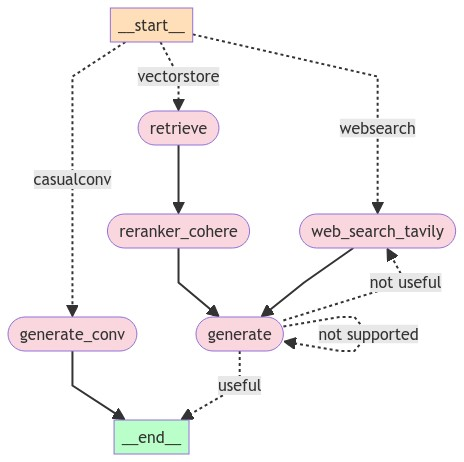

In [73]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)